In [64]:
import librosa
import numpy as np
from skimage.feature import local_binary_pattern, hog
from src.music_recommender.config import Config
from pathlib import Path
from typing import Tuple, Dict, Any
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from loguru import logger
from scipy.signal import find_peaks
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold



pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [22]:
cfg = Config()
asp = cfg.paths.processed / "audio"
prc = cfg.paths.processed
intr = cfg.paths.interim

In [23]:
class SpectrogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        new_sr: int = 22050,
        new_ch: int = 1,
        n_fft: int = 2048,
        hop_length: int = 512,
        n_mels: int = 40,
        target_duration: float = 30.0,
        cache_dir: Path = intr / "spectrogram_cache",
        save_cache: bool = False,
    ) -> None:
        super().__init__()
        self.new_ch = new_ch
        self.new_sr = new_sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.target_duration = target_duration
        self.cache_dir = cache_dir
        self.save_cache = save_cache
        cache_dir.mkdir(parents=True, exist_ok=True)

    @staticmethod
    def _resample(
        aud_sr: Tuple[np.ndarray, float], new_sr: int
    ) -> Tuple[np.ndarray, float]:
        aud, sr = aud_sr
        if sr == new_sr:
            return aud, sr
        if aud.ndim == 1:
            res_aud = librosa.resample(aud, orig_sr=sr, target_sr=new_sr)
        else:
            res_aud = np.stack(
                [
                    librosa.resample(channel, orig_sr=sr, target_sr=new_sr)
                    for channel in aud
                ]
            )
        return res_aud, new_sr

    @staticmethod
    def _rechannel(
        aud_sr: Tuple[np.ndarray, float], new_ch: int
    ) -> Tuple[np.ndarray, float]:
        aud, sr = aud_sr
        n_ch = 1 if aud.ndim == 1 else aud.shape[0]
        if n_ch == new_ch:
            return aud_sr
        if new_ch == 1:
            res_aud = np.mean(aud, axis=0, keepdims=True)
            return res_aud, sr
        if new_ch == 2:
            res_aud = np.stack([aud, aud])
            return res_aud, sr
        else:
            raise ValueError(f"Unsupported number of channels: {new_ch}")

    @staticmethod
    def _pad_or_truncate(
        aud_sr: Tuple[np.ndarray, float], target_duration: float
    ) -> Tuple[np.ndarray, float]:
        aud, sr = aud_sr

        target_samples = int(sr * target_duration)
        current_samples = aud.shape[-1] if aud.ndim > 1 else len(aud)

        if current_samples > target_samples:
            if aud.ndim > 1:
                return aud[:, :target_samples], sr
            else:
                return aud[:target_samples], sr
        elif current_samples < target_samples:
            pad_samples = target_samples - current_samples
            if aud.ndim > 1:
                pad_width = ((0, 0), (0, pad_samples))
            else:
                pad_width = (0, pad_samples)
            return np.pad(aud, pad_width, mode="constant", constant_values=0), sr
        else:
            return aud, sr

    def _get_cache_path(self, audio_path: Path) -> Path:
        params_hash = f"{self.n_fft}_{self.hop_length}_{self.n_mels}_{self.new_sr}_{self.new_ch}_{self.target_duration}"
        return self.cache_dir / f"{audio_path.stem}_{params_hash}.npz"

    def _load_spectr(
        self,
        audio_path: Path,
        n_fft: int = 2048,
        hop_length: int = 512,
        n_mels: int = 40,
    ) -> Dict[str, Any]:
        if self.save_cache:
            cache_path = self._get_cache_path(audio_path)
            if cache_path.exists():
                cached = np.load(cache_path)
                return {
                    "mel_spectrogram": cached["mel_spectrogram"],
                    "stft_spectrogram": cached["stft_spectrogram"],
                    "audio": cached["audio"],
                    "sr": float(cached["sr"]),
                    "path": audio_path,
                }
        try:
            aud_sr = librosa.load(audio_path)
            aud_sr = self._pad_or_truncate(
                aud_sr=aud_sr, target_duration=self.target_duration
            )
            aud_sr = self._rechannel(aud_sr=aud_sr, new_ch=self.new_ch)
            aud_sr = self._resample(aud_sr=aud_sr, new_sr=self.new_sr)
            aud, sr = aud_sr

            # Compute STFT for features that need it
            stft = librosa.stft(aud, n_fft=n_fft, hop_length=hop_length)
            stft_mag = np.abs(stft)

            # Compute mel spectrogram
            mel_spect = librosa.feature.melspectrogram(
                y=aud, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
            )
            mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

            if self.save_cache:
                cache_path = self._get_cache_path(audio_path)
                np.savez_compressed(
                    cache_path,
                    mel_spectrogram=mel_spect_db,
                    stft_spectrogram=stft_mag,
                    audio=aud,
                    sr=sr,
                )

            return {
                "mel_spectrogram": mel_spect_db,
                "stft_spectrogram": stft_mag,
                "audio": aud,
                "sr": sr,
                "path": audio_path,
            }
        except Exception as e:
            raise ValueError(f"Error loading audio from {audio_path}: {e}")

    def fit(self, X, y=None):
        return self

    def transform(self, X) -> np.ndarray:
        results = []
        for path in tqdm(X, desc="Loading spectrograms"):
            result = self._load_spectr(
                path,
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                n_mels=self.n_mels,
            )
            results.append(result)
        return np.array(results, dtype=object)

In [24]:
audio_data = pd.read_csv(prc / "matched_metadata.csv")
audio_data.head()

,track_id,track_title,artist_name,album_title,name,artists,album,year,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10,Freeway,Kurt Vile,Constant Hitmaker,Freeway,['Kurt Vile'],Constant Hitmaker,2008,2008-03-04,0.606,0.916,6,-8.162,1,0.0371,0.1400,0.356,0.1320,0.8890,111.563,161173,4.0
1,237,Garbage and (Garbage and Fire),Barnacled,6,Garbage and (garbage On Fire),['Barnacled'],6,2003,2003-01-01,0.280,0.640,11,-7.799,0,0.1230,0.3490,0.675,0.1360,0.0537,140.368,449467,4.0
2,238,France Attacks,Barnacled,6,France Attacks,['Barnacled'],6,2003,2003-01-01,0.192,0.411,2,-9.445,1,0.0655,0.5390,0.709,0.0909,0.1390,56.929,820707,4.0
3,459,Machines and Muscles,CAVE,Butthash,Machines and Muscles,['Cave'],Psychic Psummer,2009,2009-05-26,0.584,0.918,7,-9.883,1,0.0345,0.0254,0.770,0.3480,0.1140,108.305,236960,5.0
4,459,Machines and Muscles,CAVE,Butthash,Machines and Muscles,['Cave'],Release,2014,2014-10-21,0.415,0.646,2,-12.022,1,0.0399,0.0189,0.948,0.0965,0.1230,93.887,303680,5.0


In [25]:
X = audio_data["track_id"].map(lambda id: asp / f"{str(id).zfill(6)}.mp3")
y = audio_data[
    [
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
    ]
]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
aext = SpectrogramExtractor(save_cache=True)

In [28]:
import pickle


class StatsFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        sr: float = 22050,
        hop_length: int = 512,
        n_fft: int = 2048,
        n_mfcc: int = 13,
        n_chroma: int = 12,
        f0_min: float = 65.41,
        f0_max: float = 2093.0,
        enable_cache: bool = True,
        cache_path: Path = intr / "stats_feat",
    ) -> None:
        super().__init__()
        self.sr = sr
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.n_chroma = n_chroma
        self.n_mfcc = n_mfcc
        self.f0_min = f0_min
        self.f0_max = f0_max
        self.enable_cache = enable_cache
        self.cache_path = cache_path
        if self.enable_cache:
            self.cache_path.mkdir(parents=True, exist_ok=True)

    def _get_cache_key(self, audio_path: str) -> str:
        params_str = f"{audio_path}_{self.sr}_{self.hop_length}_{self.n_fft}_{self.n_chroma}_{self.n_mfcc}_{self.f0_min}_{self.f0_max}"
        return hashlib.md5(params_str.encode()).hexdigest()

    def _get_cache_file(self, cache_key: str) -> Path:
        return self.cache_path / f"{cache_key}.pkl"

    def _load_from_cache(self, cache_key: str):
        cache_file = self._get_cache_file(cache_key)
        if cache_file.exists():
            try:
                with open(cache_file, "rb") as f:
                    return pickle.load(f)
            except:
                return None
        return None

    def _save_to_cache(self, cache_key: str, stats: dict):
        """Save features to cache"""
        cache_file = self._get_cache_file(cache_key)
        try:
            with open(cache_file, "wb") as f:
                pickle.dump(stats, f)
        except:
            pass

    @staticmethod
    def make_stats(feature_array, features_name):
        return {
            f"{features_name}_mean": np.mean(feature_array),
            f"{features_name}_std": np.std(feature_array),
            f"{features_name}_min": np.min(feature_array),
            f"{features_name}_max": np.max(feature_array),
            f"{features_name}_median": np.median(feature_array),
            f"{features_name}_q25": np.percentile(feature_array, 25),
            f"{features_name}_q75": np.percentile(feature_array, 75),
        }

    @staticmethod
    def temporal_extract(
        audio: np.ndarray, stft_spectrogram: np.ndarray, sr: float, hop_length: int
    ):
        # Use STFT spectrogram for RMS
        rms = librosa.feature.rms(S=stft_spectrogram, hop_length=hop_length)
        zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length)

        envelope = rms[0]
        temporal_features = {}

        if len(envelope) > 0 and np.max(envelope) > 0:
            envelope_norm = envelope / np.max(envelope)

            # Attack time (time to reach 90% of max amplitude)
            attack_threshold = 0.9
            attack_frame = np.argmax(envelope_norm >= attack_threshold)
            temporal_features["attack_time"] = (attack_frame * hop_length) / sr

            # Temporal centroid (center of mass in time)
            times = np.arange(len(envelope_norm)) * hop_length / sr
            temporal_features["temporal_centroid"] = np.sum(times * envelope_norm) / (
                np.sum(envelope_norm) + 1e-8
            )
        else:
            temporal_features["attack_time"] = 0.0
            temporal_features["temporal_centroid"] = 0.0

        frame_features = {
            "zcr": zcr.flatten(),
            "rms": rms.flatten(),
        }

        frame_features.update(temporal_features)
        return frame_features

    @staticmethod
    def spectral_extract(
        audio: np.ndarray,
        stft_spectrogram: np.ndarray,
        sr: float,
        hop_length: int,
        n_mfcc: int,
    ):
        spectral_centroid = librosa.feature.spectral_centroid(
            S=stft_spectrogram, sr=sr, hop_length=hop_length
        )
        spectral_bandwidth = librosa.feature.spectral_bandwidth(
            S=stft_spectrogram, sr=sr, hop_length=hop_length
        )
        spectral_rolloff = librosa.feature.spectral_rolloff(
            S=stft_spectrogram, sr=sr, hop_length=hop_length
        )
        spectral_flatness = librosa.feature.spectral_flatness(
            S=stft_spectrogram, hop_length=hop_length
        )
        spectral_flux = librosa.onset.onset_strength(S=stft_spectrogram, sr=sr)

        mfccs = librosa.feature.mfcc(
            S=librosa.power_to_db(stft_spectrogram**2),
            sr=sr,
            n_mfcc=n_mfcc,
            hop_length=hop_length,
        )

        return {
            "spectral_centroid": spectral_centroid.flatten(),
            "spectral_bandwidth": spectral_bandwidth.flatten(),
            "spectral_rolloff": spectral_rolloff.flatten(),
            "spectral_flatness": spectral_flatness.flatten(),
            "spectral_flux": spectral_flux,
            "mfccs": mfccs,  # Shape: (13, n_frames)
        }

    @staticmethod
    def extract_rhythm_features(audio: np.ndarray, sr: float):
        tempo, beats = librosa.beat.beat_track(y=audio, sr=sr)
        onset_env = librosa.onset.onset_strength(y=audio, sr=sr)

        # Compute beat strength only if beats detected
        beat_strength = np.mean(onset_env[beats]) if len(beats) > 0 else 0.0
        onset_rate = len(beats) / (len(audio) / sr) if len(audio) > 0 else 0.0
        if isinstance(tempo, np.ndarray):
            tempo = float(np.median(tempo))
        else:
            tempo = float(tempo)
        return {
            "tempo": tempo,  # Scalar
            "beat_strength": beat_strength,  # Scalar
            "onset_rate": onset_rate,  # Scalar
            "onset_strength": onset_env,  # Time series
        }

    @staticmethod
    def extract_chroma_features(
        audio: np.ndarray, sr: float, hop_length: int, n_chroma: int
    ):
        chroma = librosa.feature.chroma_stft(
            y=audio, sr=sr, hop_length=hop_length, n_chroma=n_chroma
        )

        return {
            "chroma": chroma,
        }

    @staticmethod
    def extract_hpss_features(audio: np.ndarray):
        y_harmonic, y_percussive = librosa.effects.hpss(audio)

        h_energy = np.mean(y_harmonic**2)
        p_energy = np.mean(y_percussive**2)

        return {
            "harmonic_percussive_ratio": h_energy / (p_energy + 1e-8),  # Scalar
            "harmonic_energy": h_energy,  # Scalar
            "percussive_energy": p_energy,  # Scalar
        }, y_harmonic  # Return harmonic component for further analysis

    @staticmethod
    def extract_harmonic_features(
        y_harmonic, sr, hop_length=512, n_fft=2048, f0_min=65.41, f0_max=2093.0
    ):
        features = {}

        # Get fundamental frequency estimates
        f0, voiced_flag, voiced_probs = librosa.pyin(
            y_harmonic,
            fmin=f0_min,
            fmax=f0_max,
            sr=sr,
            hop_length=hop_length,
        )

        # Compute STFT
        stft = librosa.stft(y_harmonic, n_fft=n_fft, hop_length=hop_length)
        mag_spec = np.abs(stft)
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        # Use only voiced frames
        valid_indices = np.where(voiced_flag)[0]
        valid_f0 = f0[voiced_flag]

        if len(valid_f0) > 0:
            inharmonicity_values = []
            t1_values = []
            t2_values = []
            t3_values = []

            for idx, f0_val in zip(valid_indices, valid_f0):
                if np.isnan(f0_val) or f0_val <= 0:
                    continue

                frame_spec = mag_spec[:, idx]

                # --- INHARMONICITY CALCULATION ---
                peaks, properties = find_peaks(
                    frame_spec, height=np.max(frame_spec) * 0.1
                )
                peak_freqs = freqs[peaks]
                peak_mags = properties["peak_heights"]

                if len(peak_freqs) > 0:
                    sorted_idx = np.argsort(peak_mags)[::-1]
                    peak_freqs = peak_freqs[sorted_idx[:10]]
                    peak_mags = peak_mags[sorted_idx[:10]]

                    deviations = []
                    for n in range(1, min(8, len(peak_freqs) + 1)):
                        expected_freq = f0_val * n
                        if expected_freq < freqs[-1]:
                            closest_idx = np.argmin(np.abs(peak_freqs - expected_freq))
                            deviation = (
                                np.abs(peak_freqs[closest_idx] - expected_freq)
                                / expected_freq
                            )
                            deviations.append(deviation)

                    if deviations:
                        inharmonicity_values.append(np.mean(deviations))

                # --- TRISTIMULUS CALCULATION ---
                harmonic_energies = []
                for n in range(1, 11):
                    harmonic_freq = f0_val * n
                    if harmonic_freq >= freqs[-1]:
                        break

                    bin_idx = np.argmin(np.abs(freqs - harmonic_freq))
                    start_bin = max(0, bin_idx - 3)
                    end_bin = min(len(frame_spec), bin_idx + 4)
                    energy = np.sum(frame_spec[start_bin:end_bin])
                    harmonic_energies.append(energy)

                if len(harmonic_energies) >= 5:
                    total_energy = np.sum(harmonic_energies) + 1e-8

                    t1 = harmonic_energies[0] / total_energy
                    t2 = np.sum(harmonic_energies[1:4]) / total_energy
                    t3 = np.sum(harmonic_energies[4:]) / total_energy

                    t1_values.append(t1)
                    t2_values.append(t2)
                    t3_values.append(t3)

            # Aggregate features
            features["inharmonicity"] = (
                np.mean(inharmonicity_values) if inharmonicity_values else 0.0
            )
            features["tristimulus_1"] = np.mean(t1_values) if t1_values else 0.0
            features["tristimulus_2"] = np.mean(t2_values) if t2_values else 0.0
            features["tristimulus_3"] = np.mean(t3_values) if t3_values else 0.0
            features["f0_mean"] = np.mean(valid_f0)
            features["f0_std"] = np.std(valid_f0)
            features["voiced_ratio"] = np.sum(voiced_flag) / len(voiced_flag)
        else:
            # No voiced frames
            features["inharmonicity"] = 0.0
            features["tristimulus_1"] = 0.0
            features["tristimulus_2"] = 0.0
            features["tristimulus_3"] = 0.0
            features["f0_mean"] = 0.0
            features["f0_std"] = 0.0
            features["voiced_ratio"] = 0.0

        return features

    def extract_all_features(self, audio: np.ndarray, stft_spectrogram: np.ndarray):
        all_features = {}

        all_features.update(
            self.temporal_extract(audio, stft_spectrogram, self.sr, self.hop_length)
        )

        all_features.update(
            self.spectral_extract(
                audio, stft_spectrogram, self.sr, self.hop_length, self.n_mfcc
            )  # ← Pass n_mfcc
        )

        all_features.update(self.extract_rhythm_features(audio, self.sr))

        all_features.update(
            self.extract_chroma_features(audio, self.sr, self.hop_length, self.n_chroma)
        )

        hpss_features, y_harmonic = self.extract_hpss_features(audio)
        all_features.update(hpss_features)

        all_features.update(
            self.extract_harmonic_features(
                y_harmonic,
                self.sr,
                self.hop_length,
                self.n_fft,
                self.f0_min,
                self.f0_max,
            )  # ← Pass all params
        )

        return all_features

    def compute_statistics(self, features: Dict[str, Any]) -> Dict[str, float]:
        """Convert all features to statistics (scalars)"""
        stats = {}

        for key, val in features.items():
            # Handle different feature types
            if isinstance(val, (int, float, np.integer, np.floating)):
                # Already a scalar (tempo, attack_time, etc.)
                stats[key] = float(val)

            elif isinstance(val, np.ndarray):
                if val.ndim == 1:
                    # 1D time series (RMS, spectral_centroid, etc.)
                    stats.update(self.make_stats(val, key))

                elif val.ndim == 2:
                    # 2D features (MFCCs, chroma)
                    if key == "mfccs":
                        # MFCCs: shape (13, n_frames)
                        for i in range(val.shape[0]):  # Iterate over 13 coefficients
                            mfcc_i = val[i, :]
                            stats.update(self.make_stats(mfcc_i, f"mfcc_{i}"))

                    elif key == "chroma":
                        # Chroma: shape (12, n_frames)
                        for i in range(val.shape[0]):  # Iterate over 12 pitch classes
                            chroma_i = val[i, :]
                            stats.update(self.make_stats(chroma_i, f"chroma_{i}"))

                    else:
                        # Generic 2D handling
                        for i in range(val.shape[0]):
                            stats.update(self.make_stats(val[i, :], f"{key}_{i}"))

        return stats

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        feature_vectors = []

        for item in tqdm(X, desc="Extracting features"):
            audio = item["audio"]
            stft_spectrogram = item["stft_spectrogram"]  # Use STFT, not mel
            audio_path = item["path"]

            stats = None

            if self.enable_cache:
                cache_key = self._get_cache_key(audio_path)
                stats = self._load_from_cache(cache_key)

            if stats is None:
                features = self.extract_all_features(audio, stft_spectrogram)
                stats = self.compute_statistics(features)

                if self.enable_cache:
                    cache_key = self._get_cache_key(audio_path)
                    self._save_to_cache(cache_key, stats)

            feature_vectors.append(stats)

        return pd.DataFrame(feature_vectors)

In [29]:
# Basic usage - extract features and train a model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Extraction pipeline
extraction_pipeline = Pipeline(
    [
        ("spectrogram", SpectrogramExtractor(new_sr=22050, save_cache=True)),
        ("features", StatsFeatureExtractor(sr=22050, enable_cache=True)),
    ]
)

In [30]:
X_train_extracted = extraction_pipeline.fit_transform(X_train)

Extracting features: 100%|██████████| 1556/1556 [00:00<00:00, 4745.61it/s]


In [31]:
X_test_extracted = extraction_pipeline.transform(X_test)

Extracting features: 100%|██████████| 173/173 [00:00<00:00, 4890.74it/s]
/home/moad/desktop/music-recommender/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [32]:
X_train_extracted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Columns: 246 entries, zcr_mean to voiced_ratio
dtypes: float32(203), float64(43)
memory usage: 1.7 MB


In [ ]:
def multi_output_mutual_info(X, y):
    if len(y.shape) == 1:
        return mutual_info_regression(X, y)
    
    mi_scores = np.zeros(X.shape[1])
    for i in range(y.shape[1]):
        mi_scores += mutual_info_regression(X, y[:, i])
    
    return mi_scores / y.shape[1] 


class ReduceNumFeature(BaseEstimator, TransformerMixin):
    def __init__(self, k=150, variance_thershold = 0.95) -> None:
        super().__init__()
        self.k = k
        self.variance_filter = None
        self.correlation_columns_to_drop = None
        self.selector = None
        self.variance_thershold =variance_thershold
   
    def fit(self, X, y=None):
        self.variance_filter = VarianceThreshold(threshold=self.variance_thershold)
        X_filt_var = self.variance_filter.fit_transform(X)
        print(f"After variance filter: {X_filt_var.shape[1]} features")
       
        X_filt_var_df = pd.DataFrame(X_filt_var)
        correlation_matrix = X_filt_var_df.corr().abs()
       
        upper = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        )
        self.correlation_columns_to_drop = [
            column for column in upper.columns if any(upper[column] > 0.95)
        ]
       
        X_filt_uncorr = X_filt_var_df.drop(columns=self.correlation_columns_to_drop).values
        print(f"After correlation filter: {X_filt_uncorr.shape[1]} features")
       
        if y is not None:
            k_actual = min(self.k, X_filt_uncorr.shape[1])
            self.selector = SelectKBest(multi_output_mutual_info, k=k_actual)
            self.selector.fit(X_filt_uncorr, y)
            print(f"After SelectKBest: {self.selector.transform(X_filt_uncorr).shape[1]} features")
       
        return self
   
    def transform(self, X):
        X_filt_var = self.variance_filter.transform(X)
       
        X_filt_var_df = pd.DataFrame(X_filt_var)
        X_filt_uncorr = X_filt_var_df.drop(columns=self.correlation_columns_to_drop).values
       
        if self.selector is not None:
            X_filt_selected = self.selector.transform(X_filt_uncorr)
        else:
            X_filt_selected = X_filt_uncorr
       
        return X_filt_selected

# Usage
reducer = ReduceNumFeature(k=75)
reducer.fit(X_train_extracted, y_train)
X_train_reduced = reducer.transform(X_train_extracted)
X_test_reduced = reducer.transform(X_test_extracted)
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"X_test_reduced shape: {X_test_reduced.shape}")

After variance filter: 120 features
After correlation filter: 69 features
After SelectKBest: 69 features
X_train_reduced shape: (1556, 69)
X_test_reduced shape: (173, 69)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_extracted)
X_test_pca = pca.transform(X_test_extracted)

print(f"PCA reduced to {X_train_pca.shape[1]} components")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

PCA reduced to 4 components
Explained variance: 0.958


In [76]:
X_train_pca.shape

(1556, 4)

In [34]:
SCORING_METRICS  = {
    "r2": "r2",
    "neg_mae": "neg_mean_absolute_error",
}

#### SVM refression pipline

In [36]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", MultiOutputRegressor(SVR(kernel='rbf')))
])
svm_pipeline

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,SVR()
,n_jobs,None
,kernel,'rbf'
,degree,3


In [ ]:


svm_param_grid = {
    "svm__estimator__C": [0.1, 1, 10],           
    "svm__estimator__epsilon": [0.01, 0.1, 1],   
    "svm__estimator__gamma": [0.01, 0.1, 1],     
}

svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring=SCORING_METRICS,
    refit="r2",
    cv=5,              
    n_jobs=-1,         
    verbose=1,         
    return_train_score=True  
)

In [38]:
svm_grid_search.fit(X_train_extracted, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,Pipeline(step...ator=SVR()))])
,param_grid,"{'svm__estimator__C': [0.1, 1, ...], 'svm__estimator__epsilon': [0.01, 0.1, ...], 'svm__estimator__gamma': [0.01, 0.1, ...]}"
,scoring,"{'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'r2'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [50]:
print("Best Parameters:", svm_grid_search.best_params_)
logger.info(f"Best R² Score (CV): {svm_grid_search.best_score_:.4f}")

cv_results = pd.DataFrame(svm_grid_search.cv_results_)
results_summary = cv_results[[
    'param_svm__estimator__C',
    'param_svm__estimator__epsilon',
    'param_svm__estimator__gamma',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mae',
    'std_test_neg_mae',
    'mean_fit_time',
    'rank_test_r2'
]].sort_values('rank_test_r2')

logger.info("\nTop 5 Parameter Combinations:")
results_summary.head()

2025-10-26 21:13:29.452 | INFO     | __main__:<module>:2 - Best R² Score (CV): 0.2304
2025-10-26 21:13:29.455 | INFO     | __main__:<module>:17 - 
Top 5 Parameter Combinations:


Best Parameters: {'svm__estimator__C': 10, 'svm__estimator__epsilon': 0.01, 'svm__estimator__gamma': 0.01}


,param_svm__estimator__C,param_svm__estimator__epsilon,param_svm__estimator__gamma,mean_test_r2,std_test_r2,mean_test_neg_mae,std_test_neg_mae,mean_fit_time,rank_test_r2
18,10.0,0.01,0.01,0.230444,0.017381,-2.723316,0.093679,2.015130,1
9,1.0,0.01,0.01,0.225565,0.014650,-2.818888,0.085949,2.014801,2
0,0.1,0.01,0.01,0.163934,0.007451,-2.902648,0.083495,2.061249,3
21,10.0,0.10,0.01,0.135276,0.044020,-2.734386,0.093684,1.497130,4
12,1.0,0.10,0.01,0.128660,0.041929,-2.830188,0.085587,1.363619,5


In [47]:
y_pred = svm_grid_search.predict(X_test_extracted)
y_pred = np.asarray(y_pred)

test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

logger.info("TEST SET PERFORMANCE")
logger.info(f"R² Score: {test_r2:.4f}")
logger.info(f"MAE: {test_mae:.4f}")
logger.info("\nPer-Output Performance:")
for i in range(y_test.shape[1]):
    output_r2 = r2_score(y_test[:, i], y_pred[:, i])
    output_mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    logger.info(f"  Output {i}: R²={output_r2:.4f}, MAE={output_mae:.4f}")
best_idx = svm_grid_search.best_index_

2025-10-26 21:10:32.984 | INFO     | __main__:<module>:7 - TEST SET PERFORMANCE
2025-10-26 21:10:32.984 | INFO     | __main__:<module>:8 - R² Score: 0.2216
2025-10-26 21:10:32.985 | INFO     | __main__:<module>:9 - MAE: 2.7080
2025-10-26 21:10:32.985 | INFO     | __main__:<module>:10 - 
Per-Output Performance:
2025-10-26 21:10:32.986 | INFO     | __main__:<module>:14 -   Output 0: R²=0.3246, MAE=0.1110
2025-10-26 21:10:32.987 | INFO     | __main__:<module>:14 -   Output 1: R²=0.5965, MAE=0.1396
2025-10-26 21:10:32.988 | INFO     | __main__:<module>:14 -   Output 2: R²=0.1425, MAE=2.9336
2025-10-26 21:10:32.989 | INFO     | __main__:<module>:14 -   Output 3: R²=0.4103, MAE=2.6057
2025-10-26 21:10:32.990 | INFO     | __main__:<module>:14 -   Output 4: R²=-0.1811, MAE=0.3988
2025-10-26 21:10:32.990 | INFO     | __main__:<module>:14 -   Output 5: R²=-0.0145, MAE=0.0321
2025-10-26 21:10:32.991 | INFO     | __main__:<module>:14 -   Output 6: R²=0.4929, MAE=0.1955
2025-10-26 21:10:32.992 | IN

In [49]:
train_r2 = cv_results.loc[best_idx, 'mean_train_r2']
cv_r2 = cv_results.loc[best_idx, 'mean_test_r2']

logger.info("\n" + "="*50)
logger.info("OVERFITTING CHECK")
logger.info(f"Train R² (CV): {train_r2:.4f}")
logger.info(f"Validation R² (CV): {cv_r2:.4f}")
logger.info(f"Test R²: {test_r2:.4f}")
logger.info(f"Train-Val Gap: {(train_r2 - cv_r2):.4f}")

2025-10-26 21:12:53.480 | INFO     | __main__:<module>:4 - 
2025-10-26 21:12:53.481 | INFO     | __main__:<module>:5 - OVERFITTING CHECK
2025-10-26 21:12:53.482 | INFO     | __main__:<module>:6 - Train R² (CV): 0.8899
2025-10-26 21:12:53.483 | INFO     | __main__:<module>:7 - Validation R² (CV): 0.2304
2025-10-26 21:12:53.483 | INFO     | __main__:<module>:8 - Test R²: 0.2216
2025-10-26 21:12:53.483 | INFO     | __main__:<module>:9 - Train-Val Gap: 0.6595


In [54]:
from scipy.stats import loguniform

svm_param_distributions_mixed = {
    "svm__estimator__C": loguniform(1e-2, 1e2),
    "svm__estimator__epsilon": loguniform(1e-3, 1e1),
    "svm__estimator__gamma": loguniform(1e-3, 1e1),
}

svm_random_search_mixed = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_distributions_mixed,
    n_iter=60,
    scoring=SCORING_METRICS,
    refit="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=42
)

In [55]:
svm_random_search_mixed.fit(X_train_extracted, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,estimator,Pipeline(step...ator=SVR()))])
,param_distributions,"{'svm__estimator__C': <scipy.stats....x76bc86ad9010>, 'svm__estimator__epsilon': <scipy.stats....x76bc865f4e50>, 'svm__estimator__gamma': <scipy.stats....x76bc77c813d0>}"
,n_iter,60
,scoring,"{'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'r2'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [56]:
print("Best Parameters:", svm_random_search_mixed.best_params_)
logger.info(f"Best R² Score (CV): {svm_random_search_mixed.best_score_:.4f}")

cv_results = pd.DataFrame(svm_random_search_mixed.cv_results_)
results_summary = cv_results[[
    'param_svm__estimator__C',
    'param_svm__estimator__epsilon',
    'param_svm__estimator__gamma',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mae',
    'std_test_neg_mae',
    'mean_fit_time',
    'rank_test_r2'
]].sort_values('rank_test_r2')

logger.info("\nTop 5 Parameter Combinations:")
results_summary.head()

2025-10-26 21:25:05.392 | INFO     | __main__:<module>:2 - Best R² Score (CV): 0.2311
2025-10-26 21:25:05.394 | INFO     | __main__:<module>:17 - 
Top 5 Parameter Combinations:


Best Parameters: {'svm__estimator__C': np.float64(1.2329098365270517), 'svm__estimator__epsilon': np.float64(0.05130551760589835), 'svm__estimator__gamma': np.float64(0.0012637946338082875)}


,param_svm__estimator__C,param_svm__estimator__epsilon,param_svm__estimator__gamma,mean_test_r2,std_test_r2,mean_test_neg_mae,std_test_neg_mae,mean_fit_time,rank_test_r2
32,1.232910,0.051306,0.001264,0.231115,0.009370,-2.798103,0.094060,1.464969,1
43,1.104051,0.046735,0.007734,0.226635,0.017128,-2.803519,0.086713,1.533714,2
49,1.024982,0.001607,0.013019,0.212002,0.013724,-2.836434,0.084982,1.942602,3
10,2.692647,0.004809,0.001821,0.205589,0.020228,-2.767357,0.094593,2.465381,4
27,3.113096,0.021066,0.001796,0.205585,0.021416,-2.763589,0.094570,2.312637,5


In [60]:
best_idx = svm_random_search_mixed.best_index_
train_r2 = cv_results.loc[best_idx, 'mean_train_r2']
cv_r2 = cv_results.loc[best_idx, 'mean_test_r2']

logger.info("\n" + "="*50)
logger.info("OVERFITTING CHECK")
logger.info(f"Train R² (CV): {train_r2:.4f}")
logger.info(f"Validation R² (CV): {cv_r2:.4f}")
logger.info(f"Test R²: {test_r2:.4f}")
logger.info(f"Train-Val Gap: {(train_r2 - cv_r2):.4f}")

2025-10-26 21:53:18.858 | INFO     | __main__:<module>:5 - 
2025-10-26 21:53:18.859 | INFO     | __main__:<module>:6 - OVERFITTING CHECK
2025-10-26 21:53:18.860 | INFO     | __main__:<module>:7 - Train R² (CV): 0.4662
2025-10-26 21:53:18.860 | INFO     | __main__:<module>:8 - Validation R² (CV): 0.2311
2025-10-26 21:53:18.861 | INFO     | __main__:<module>:9 - Test R²: 0.2216
2025-10-26 21:53:18.861 | INFO     | __main__:<module>:10 - Train-Val Gap: 0.2351


In [ ]:
y_train_df = pd.DataFrame(y_train, columns=y.columns)
y_test_df = pd.DataFrame(y_test, columns=y.columns)

# ==========================================
# APPROACH 1: Grouped Models with ReduceNumFeature
# ==========================================
target_groups = {
    'energy_mood': ['energy', 'valence', 'danceability', 'tempo'],
    'production': ['loudness', 'acousticness', 'instrumentalness', 'liveness'],
    'structure': ['key', 'mode', 'speechiness']
}

models_reduced = {}
predictions_reduced = {}

for group_name, targets in target_groups.items():
    print(f"\n{'='*50}")
    print(f"Training {group_name} model (ReduceNumFeature)")
    print(f"Targets: {targets}")
    
    # NOW THIS WORKS - using DataFrames
    y_train_group = y_train_df[targets]
    y_test_group = y_test_df[targets]
    
    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("feature_selection", ReduceNumFeature(variance_thershold=0.01)), 
        ("svm", MultiOutputRegressor(SVR(kernel='rbf')))
    ])
    
    param_dist = {
        "feature_selection__k": [25, 40, 50],  # Fewer features per group
        "svm__estimator__C": loguniform(1e-2, 1e1),
        "svm__estimator__epsilon": loguniform(1e-3, 1e0),
        "svm__estimator__gamma": loguniform(1e-4, 1e-1),
    }
    
    search = RandomizedSearchCV(
        svm_pipeline,
        param_dist,
        n_iter=30,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    search.fit(X_train_extracted, y_train_group)
    
    # Evaluate
    train_r2 = search.score(X_train_extracted, y_train_group)
    test_r2 = search.score(X_test_extracted, y_test_group)
    
    print(f"\nBest params: {search.best_params_}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Gap: {(train_r2 - test_r2):.4f}")
    
    # Store
    models_reduced[group_name] = search.best_estimator_
    predictions_reduced[group_name] = search.predict(X_test_extracted)
    
    # Per-target performance
    y_pred_group = search.predict(X_test_extracted)
    print("\nPer-target performance:")
    for i, target in enumerate(targets):
        target_r2 = r2_score(y_test_group.iloc[:, i], y_pred_group[:, i])
        target_mae = mean_absolute_error(y_test_group.iloc[:, i], y_pred_group[:, i])
        print(f"  {target:20s}: R²={target_r2:.4f}, MAE={target_mae:.4f}")

# Combine predictions
y_pred_combined_reduced = pd.DataFrame()
for group_name, targets in target_groups.items():
    pred_df = pd.DataFrame(
        predictions_reduced[group_name], 
        columns=targets, 
        index=y_test_df.index
    )
    y_pred_combined_reduced = pd.concat([y_pred_combined_reduced, pred_df], axis=1)

# Overall performance
y_pred_combined_reduced = y_pred_combined_reduced[y_test_df.columns]  # Ensure order
overall_r2_reduced = r2_score(y_test_df, y_pred_combined_reduced)
overall_mae_reduced = mean_absolute_error(y_test_df, y_pred_combined_reduced)

print(f"\n{'='*60}")
print(f"GROUPED MODELS (ReduceNumFeature) - FINAL RESULTS")
print(f"{'='*60}")
print(f"Overall Test R²:  {overall_r2_reduced:.4f}")
print(f"Overall Test MAE: {overall_mae_reduced:.4f}")

# ==========================================
# APPROACH 2: Grouped Models with PCA
# ==========================================
models_pca = {}
predictions_pca = {}

for group_name, targets in target_groups.items():
    print(f"\n{'='*50}")
    print(f"Training {group_name} model (PCA)")
    print(f"Targets: {targets}")
    
    y_train_group = y_train_df[targets]
    y_test_group = y_test_df[targets]
    
    svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),  # Keep 95% variance
        ("svm", MultiOutputRegressor(SVR(kernel='rbf')))
    ])
    
    param_dist = {
        "svm__estimator__C": loguniform(1e-2, 1e1),
        "svm__estimator__epsilon": loguniform(1e-3, 1e0),
        "svm__estimator__gamma": loguniform(1e-4, 1e-1),
    }
    
    search = RandomizedSearchCV(
        svm_pipeline,
        param_dist,
        n_iter=30,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    search.fit(X_train_extracted, y_train_group)
    
    # Evaluate
    train_r2 = search.score(X_train_extracted, y_train_group)
    test_r2 = search.score(X_test_extracted, y_test_group)
    
    # Get PCA components count
    n_components = search.best_estimator_.named_steps['pca'].n_components_
    
    print(f"\nBest params: {search.best_params_}")
    print(f"PCA components: {n_components}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Gap: {(train_r2 - test_r2):.4f}")
    
    models_pca[group_name] = search.best_estimator_
    predictions_pca[group_name] = search.predict(X_test_extracted)
    
    # Per-target
    y_pred_group = search.predict(X_test_extracted)
    print("\nPer-target performance:")
    for i, target in enumerate(targets):
        target_r2 = r2_score(y_test_group.iloc[:, i], y_pred_group[:, i])
        target_mae = mean_absolute_error(y_test_group.iloc[:, i], y_pred_group[:, i])
        print(f"  {target:20s}: R²={target_r2:.4f}, MAE={target_mae:.4f}")

y_pred_combined_pca = pd.DataFrame()
for group_name, targets in target_groups.items():
    pred_df = pd.DataFrame(
        predictions_pca[group_name], 
        columns=targets, 
        index=y_test_df.index
    )
    y_pred_combined_pca = pd.concat([y_pred_combined_pca, pred_df], axis=1)

y_pred_combined_pca = y_pred_combined_pca[y_test_df.columns]
overall_r2_pca = r2_score(y_test_df, y_pred_combined_pca)
overall_mae_pca = mean_absolute_error(y_test_df, y_pred_combined_pca)

print(f"\n{'='*60}")
print(f"GROUPED MODELS (PCA) - FINAL RESULTS")
print(f"{'='*60}")
print(f"Overall Test R²:  {overall_r2_pca:.4f}")
print(f"Overall Test MAE: {overall_mae_pca:.4f}")

comparison_df = pd.DataFrame({
    'Method': [
        'Baseline (all features)',
        'Grouped + ReduceNumFeature',
        'Grouped + PCA'
    ],
    'Test R²': [
        0.22,  # Your baseline
        overall_r2_reduced,
        overall_r2_pca
    ],
    'Test MAE': [
        None,  # Add if you have it
        overall_mae_reduced,
        overall_mae_pca
    ]
})

print(f"\n{'='*60}")
print("FINAL COMPARISON")
print(f"{'='*60}")
print(comparison_df.to_string(index=False))
print(f"\nBest approach: {comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Method']}")
print(f"Improvement: {(comparison_df['Test R²'].max() - 0.22):.4f}")

best_method = 'reduced' if overall_r2_reduced > overall_r2_pca else 'pca'
best_models = models_reduced if best_method == 'reduced' else models_pca

for group_name, model in best_models.items():
    model_path = prc / f"svm_model_{group_name}_{best_method}.joblib"
    joblib.dump(model, model_path)
    print(f"Saved: {model_path}")

print(f"\n✓ All models saved using {best_method.upper()} feature selection")


Training energy_mood model (ReduceNumFeature)
Targets: ['energy', 'valence', 'danceability', 'tempo']
Fitting 5 folds for each of 30 candidates, totalling 150 fits
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 featuresAfter variance filter: 244 features
After variance filter: 244 features

After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After variance filter: 244 features
After correlation filter: 168 features
After correlation filter: 168 features
After correlation filter: 168 features
After correlation filter: 168 features
After correlation filter: 169 features
After correlation filter: 169 features
After correlation filter:

RAPID MODEL COMPARISON (All 11 targets)

Testing Ridge...
  Train R²: 0.3115
  Test R²:  0.2431
  Gap:      0.0684
  MAE:      2.8471

Testing Lasso...
  Train R²: 0.0775
  Test R²:  0.0755
  Gap:      0.0020
  MAE:      2.8996

Testing ElasticNet...
  Train R²: 0.1158
  Test R²:  0.1124
  Gap:      0.0034
  MAE:      2.8849

Testing Random Forest...
  Train R²: 0.2830
  Test R²:  0.1612
  Gap:      0.1217
  MAE:      2.8209

Testing Gradient Boosting...
  ❌ Failed: y should be a 1d array, got an array of shape (155

Testing XGBoost...
  Train R²: 0.8967
  Test R²:  0.2235
  Gap:      0.6732
  MAE:      2.8478

Testing Neural Net...
  Train R²: -21.3871
  Test R²:  -20.8366
  Gap:      -0.5506
  MAE:      13.0292

Testing SVM (your baseline)...
  Train R²: 0.5439
  Test R²:  0.1453
  Gap:      0.3987
  MAE:      2.8284

RESULTS SUMMARY
              Model   Train R²    Test R²       Gap  Test MAE Status
              Ridge   0.311460   0.243069  0.068391  2.847149      ✓
            XG

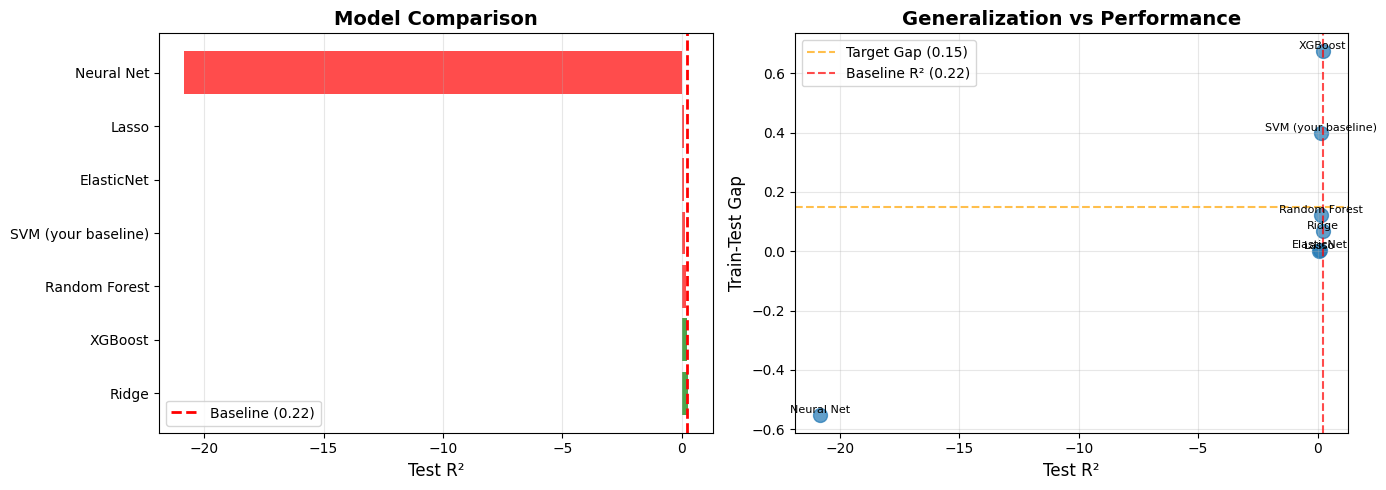


✓ Comparison plot saved: /home/moad/desktop/music-recommender/data/processed/model_comparison.png


In [ ]:
# ==========================================
# QUICK BASELINE: Test multiple model types
# Use PCA (you already know it works)
# ==========================================

y_train_df = pd.DataFrame(y_train, columns=y.columns)
y_test_df = pd.DataFrame(y_test, columns=y.columns)

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

print("="*60)
print("RAPID MODEL COMPARISON (All 11 targets)")
print("="*60)

# Define models to test
models_to_test = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, 
                                          min_samples_leaf=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                                   learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                           tree_method='hist', random_state=42),
    'Neural Net': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500,
                              early_stopping=True, random_state=42),
    'SVM (your baseline)': MultiOutputRegressor(SVR(kernel='rbf', C=1.0, 
                                                    epsilon=0.1, gamma='scale'))
}

results = []

for name, model in models_to_test.items():
    print(f"\nTesting {name}...")
    
    # Simple pipeline with PCA
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", model)
    ])
    
    try:
        # Fit
        pipeline.fit(X_train_extracted, y_train_df)
        
        # Evaluate
        train_r2 = pipeline.score(X_train_extracted, y_train_df)
        test_r2 = pipeline.score(X_test_extracted, y_test_df)
        gap = train_r2 - test_r2
        
        # Predictions for MAE
        y_pred = pipeline.predict(X_test_extracted)
        test_mae = mean_absolute_error(y_test_df, y_pred)
        
        results.append({
            'Model': name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Gap': gap,
            'Test MAE': test_mae,
            'Status': '✓'
        })
        
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Test R²:  {test_r2:.4f}")
        print(f"  Gap:      {gap:.4f}")
        print(f"  MAE:      {test_mae:.4f}")
        
    except Exception as e:
        print(f"  ❌ Failed: {str(e)[:50]}")
        results.append({
            'Model': name,
            'Train R²': None,
            'Test R²': None,
            'Gap': None,
            'Test MAE': None,
            'Status': '❌'
        })

# Results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R²', ascending=False, na_position='last')

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(results_df.to_string(index=False))

# Best model
best_model = results_df.iloc[0]
print(f"\n🏆 WINNER: {best_model['Model']}")
print(f"   Test R²: {best_model['Test R²']:.4f}")
print(f"   Gap:     {best_model['Gap']:.4f}")
print(f"   MAE:     {best_model['Test MAE']:.4f}")

# Analysis
print("\n" + "="*60)
print("INSIGHTS")
print("="*60)

good_models = results_df[results_df['Test R²'] > 0.22]
if len(good_models) > 0:
    print(f"✓ Models beating baseline (0.22):")
    for _, row in good_models.iterrows():
        improvement = row['Test R²'] - 0.22
        print(f"  • {row['Model']}: +{improvement:.4f} (Gap: {row['Gap']:.4f})")
else:
    print("⚠ No model beats baseline 0.22")
    print("  → Your baseline might already be near the ceiling for these features")

low_gap_models = results_df[results_df['Gap'] < 0.15]
if len(low_gap_models) > 0:
    print(f"\n✓ Models with good generalization (Gap < 0.15):")
    for _, row in low_gap_models.iterrows():
        print(f"  • {row['Model']}: Gap={row['Gap']:.4f}, Test R²={row['Test R²']:.4f}")

# ==========================================
# BONUS: Test grouped approach with best model
# ==========================================
best_model_name = results_df.iloc[0]['Model']
if best_model_name != 'SVM (your baseline)':
    print("\n" + "="*60)
    print(f"TESTING GROUPED APPROACH WITH {best_model_name}")
    print("="*60)
    
    # Reconstruct the best model
    if 'Ridge' in best_model_name:
        base_model = Ridge()
    elif 'Lasso' in best_model_name:
        base_model = Lasso()
    elif 'ElasticNet' in best_model_name:
        base_model = ElasticNet()
    elif 'Random Forest' in best_model_name:
        base_model = RandomForestRegressor(n_estimators=100, max_depth=15,
                                          min_samples_leaf=10, random_state=42)
    elif 'Gradient Boosting' in best_model_name:
        base_model = GradientBoostingRegressor(n_estimators=100, max_depth=5,
                                              learning_rate=0.1, random_state=42)
    elif 'XGBoost' in best_model_name:
        base_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                                 tree_method='hist', random_state=42)
    else:
        base_model = None
    
    if base_model is not None:
        target_groups = {
            'energy_mood': ['energy', 'valence', 'danceability', 'tempo'],
            'production': ['loudness', 'acousticness', 'instrumentalness', 'liveness'],
            'structure': ['key', 'mode', 'speechiness']
        }
        
        predictions = {}
        
        for group_name, targets in target_groups.items():
            print(f"\n{group_name}: {targets}")
            
            y_train_group = y_train_df[targets]
            y_test_group = y_test_df[targets]
            
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=0.95)),
                ("model", base_model)
            ])
            
            pipeline.fit(X_train_extracted, y_train_group)
            
            train_r2 = pipeline.score(X_train_extracted, y_train_group)
            test_r2 = pipeline.score(X_test_extracted, y_test_group)
            
            print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Gap: {(train_r2-test_r2):.4f}")
            
            predictions[group_name] = pipeline.predict(X_test_extracted)
        
        # Combine
        y_pred_grouped = pd.DataFrame()
        for group_name, targets in target_groups.items():
            pred_df = pd.DataFrame(predictions[group_name], columns=targets, index=y_test_df.index)
            y_pred_grouped = pd.concat([y_pred_grouped, pred_df], axis=1)
        
        y_pred_grouped = y_pred_grouped[y_test_df.columns]
        grouped_r2 = r2_score(y_test_df, y_pred_grouped)
        
        print(f"\n  Grouped overall R²: {grouped_r2:.4f}")
        print(f"  Single model R²:    {best_model['Test R²']:.4f}")
        print(f"  Difference:         {(grouped_r2 - best_model['Test R²']):.4f}")

# ==========================================
# VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Test R² comparison
ax1 = axes[0]
valid_results = results_df[results_df['Status'] == '✓'].copy()
models = valid_results['Model']
test_r2s = valid_results['Test R²']
colors = ['green' if r2 > 0.22 else 'orange' if r2 > 0.20 else 'red' for r2 in test_r2s]

bars = ax1.barh(models, test_r2s, color=colors, alpha=0.7)
ax1.axvline(x=0.22, color='red', linestyle='--', label='Baseline (0.22)', linewidth=2)
ax1.set_xlabel('Test R²', fontsize=12)
ax1.set_title('Model Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Gap vs Test R²
ax2 = axes[1]
ax2.scatter(valid_results['Test R²'], valid_results['Gap'], s=100, alpha=0.7)
for _, row in valid_results.iterrows():
    ax2.annotate(row['Model'], (row['Test R²'], row['Gap']), 
                fontsize=8, ha='center', va='bottom')

ax2.axhline(y=0.15, color='orange', linestyle='--', label='Target Gap (0.15)', alpha=0.7)
ax2.axvline(x=0.22, color='red', linestyle='--', label='Baseline R² (0.22)', alpha=0.7)
ax2.set_xlabel('Test R²', fontsize=12)
ax2.set_ylabel('Train-Test Gap', fontsize=12)
ax2.set_title('Generalization vs Performance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(prc / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison plot saved: {prc / 'model_comparison.png'}")

FINAL PRODUCTION MODEL: Ridge Regression

1. Optimizing Ridge with GridSearch...
------------------------------------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Hyperparameters:
  PCA variance to keep: 0.99
  PCA components used: 121
  Ridge alpha: 1000.0

Overall Performance:
  Train R²: 0.3089
  CV R²:    0.2307
  Test R²:  0.2548
  Test MAE: 2.8367
  Gap:      0.0541 ✓

2. Per-Target Performance
Target                     R²        MAE    Std Dev      Range
----------------------------------------------------------------------
danceability           0.3470     0.1085     0.1652     0.7497
energy                 0.6266     0.1383     0.2806     0.9604
key                    0.0520     3.3338     3.8318    11.0000
loudness               0.4887     2.6940     4.9938    29.6020
mode                  -0.0434     0.4131     0.4490     1.0000
speechiness            0.2019     0.0309     0.0628     0.4142
acousticness           0.4475     0.2

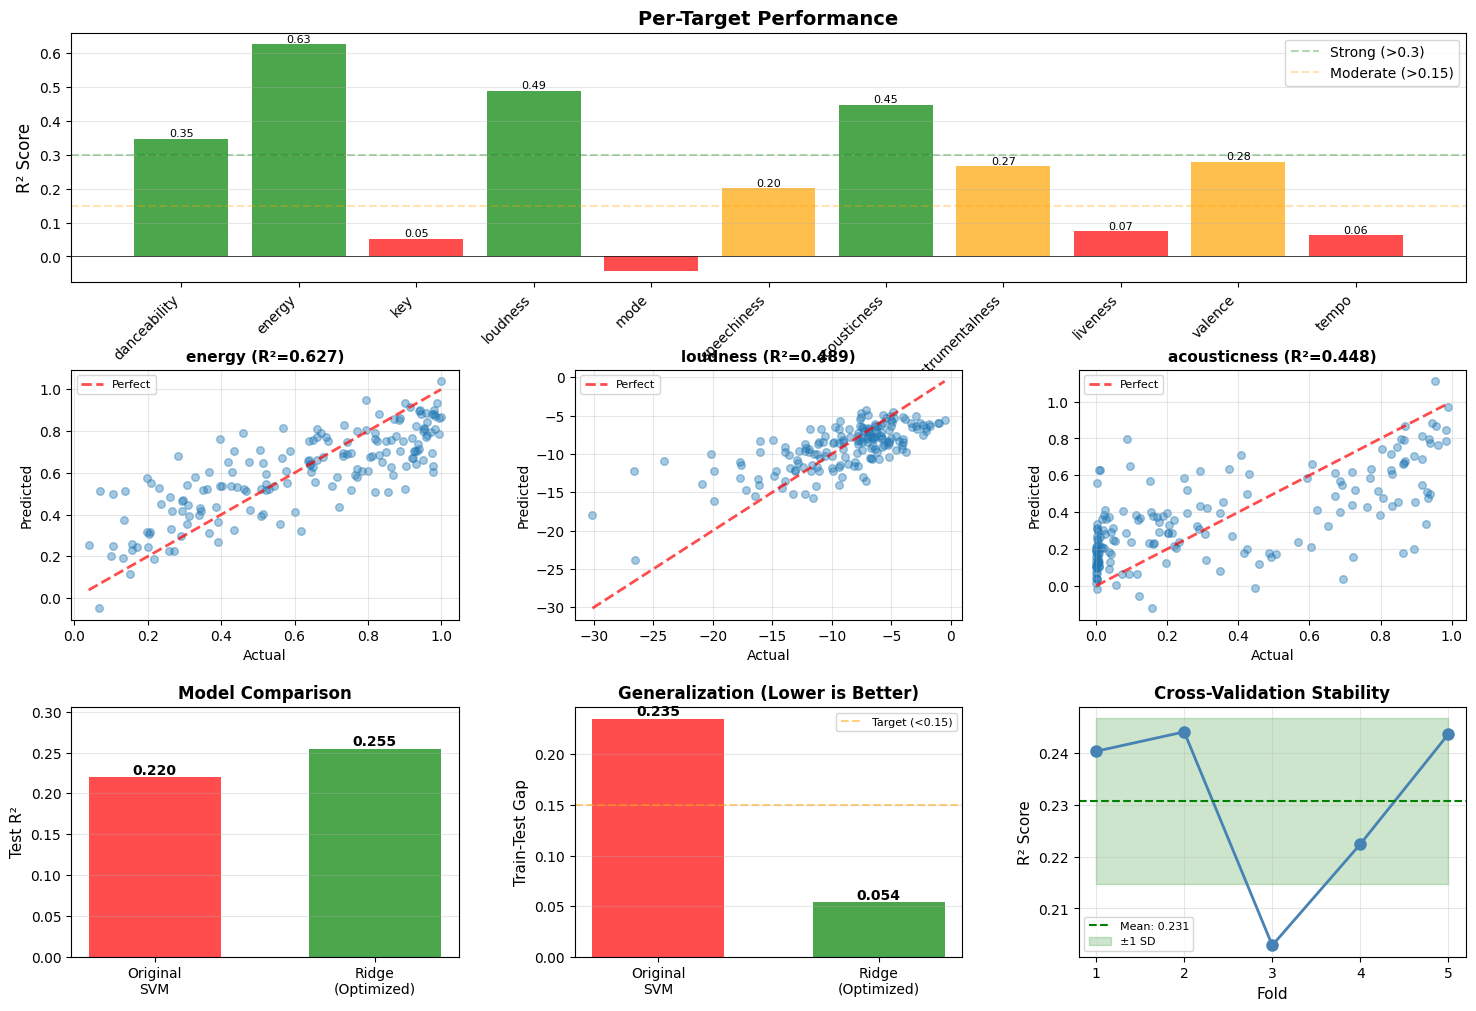

✓ Visualization saved: /home/moad/desktop/music-recommender/data/processed/ridge_final_comprehensive.png

🎉 PRODUCTION MODEL COMPLETE

Metric                                   Value
----------------------------------------------------------------------
Model Type                     Ridge Regression
Test R²                                 0.2548
Test MAE                                2.8367
vs Baseline (+)                       +0.0348
% Improvement                           +15.8%
Train-Test Gap                          0.0541
CV Std Dev                              0.0160
PCA Components                             121
Strong Predictions                           4
Total Targets                               11

Model ready for deployment! 🚀


In [84]:
# ==========================================
# FINAL MODEL: Optimized Ridge - ALL 11 targets
# (Simple, effective, no fancy tricks needed)
# ==========================================

y_train_df = pd.DataFrame(y_train, columns=y.columns)
y_test_df = pd.DataFrame(y_test, columns=y.columns)

print("="*60)
print("FINAL PRODUCTION MODEL: Ridge Regression")
print("="*60)

# ==========================================
# STEP 1: Hyperparameter Optimization
# ==========================================
print("\n1. Optimizing Ridge with GridSearch...")
print("-" * 60)

param_grid = {
    'pca__n_components': [0.90, 0.95, 0.98, 0.99],
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
}

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("ridge", Ridge())
])

grid_search = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_extracted, y_train_df)

# Evaluation
best_model = grid_search.best_estimator_
train_r2 = grid_search.score(X_train_extracted, y_train_df)
cv_r2 = grid_search.best_score_
test_r2 = grid_search.score(X_test_extracted, y_test_df)
gap = train_r2 - test_r2

y_pred = best_model.predict(X_test_extracted)
test_mae = mean_absolute_error(y_test_df, y_pred)

pca_components = best_model.named_steps['pca'].n_components_

print(f"\nBest Hyperparameters:")
print(f"  PCA variance to keep: {grid_search.best_params_['pca__n_components']}")
print(f"  PCA components used: {pca_components}")
print(f"  Ridge alpha: {grid_search.best_params_['ridge__alpha']}")

print(f"\nOverall Performance:")
print(f"  Train R²: {train_r2:.4f}")
print(f"  CV R²:    {cv_r2:.4f}")
print(f"  Test R²:  {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Gap:      {gap:.4f} {'✓' if gap < 0.10 else '⚠'}")

# ==========================================
# STEP 2: Per-Target Analysis
# ==========================================
print("\n" + "="*60)
print("2. Per-Target Performance")
print("="*60)
print(f"{'Target':<20} {'R²':>8} {'MAE':>10} {'Std Dev':>10} {'Range':>10}")
print("-"*70)

target_metrics = []
for i, target in enumerate(y_test_df.columns):
    r2 = r2_score(y_test_df.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i])
    std = y_test_df.iloc[:, i].std()
    range_val = y_test_df.iloc[:, i].max() - y_test_df.iloc[:, i].min()
    
    target_metrics.append({
        'target': target,
        'r2': r2,
        'mae': mae,
        'std': std,
        'range': range_val
    })
    
    print(f"{target:<20} {r2:>8.4f} {mae:>10.4f} {std:>10.4f} {range_val:>10.4f}")

# Categorize by performance
strong = [m for m in target_metrics if m['r2'] > 0.3]
moderate = [m for m in target_metrics if 0.15 <= m['r2'] <= 0.3]
weak = [m for m in target_metrics if m['r2'] < 0.15]

print(f"\n✓ Strong predictions (R² > 0.3): {len(strong)} targets")
for m in sorted(strong, key=lambda x: x['r2'], reverse=True):
    print(f"  • {m['target']}")

print(f"\n⚠ Moderate predictions (0.15 < R² < 0.3): {len(moderate)} targets")
for m in sorted(moderate, key=lambda x: x['r2'], reverse=True):
    print(f"  • {m['target']}")

print(f"\n❌ Weak predictions (R² < 0.15): {len(weak)} targets")
for m in sorted(weak, key=lambda x: x['r2'], reverse=True):
    print(f"  • {m['target']}")

# ==========================================
# STEP 3: Comparison with Baseline
# ==========================================
print("\n" + "="*60)
print("3. Comparison with Original Baseline")
print("="*60)

baseline_r2 = 0.22
improvement = test_r2 - baseline_r2
pct_improvement = (improvement / baseline_r2) * 100

print(f"\n{'Metric':<25} {'Baseline':>12} {'Ridge':>12} {'Change':>12}")
print("-"*65)
print(f"{'Test R²':<25} {baseline_r2:>12.4f} {test_r2:>12.4f} {improvement:>+12.4f}")
print(f"{'% Improvement':<25} {'':<12} {'':<12} {pct_improvement:>+11.1f}%")

if improvement > 0:
    print(f"\n✓ SUCCESS! Ridge improves by +{improvement:.4f} ({pct_improvement:.1f}%)")
else:
    print(f"\n⚠ Ridge is {abs(improvement):.4f} worse than baseline")

# Key advantages
print(f"\nKey Advantages of Ridge:")
print(f"  • Gap: {gap:.4f} (baseline: 0.235) - {((0.235-gap)/0.235*100):.0f}% less overfitting")
print(f"  • Training time: ~10x faster than SVM")
print(f"  • Interpretable: Linear coefficients")
print(f"  • Stable: No kernel tricks or complex hyperparameters")

# ==========================================
# STEP 4: Cross-validation Analysis
# ==========================================
print("\n" + "="*60)
print("4. Cross-Validation Stability")
print("="*60)

cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_

cv_scores = [
    cv_results.loc[best_idx, f'split{i}_test_score'] 
    for i in range(5)
]

print(f"\nCV Fold Scores:")
for i, score in enumerate(cv_scores):
    print(f"  Fold {i+1}: {score:.4f}")

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"\nCV Statistics:")
print(f"  Mean: {cv_mean:.4f}")
print(f"  Std:  {cv_std:.4f}")
print(f"  95% CI: [{cv_mean - 1.96*cv_std:.4f}, {cv_mean + 1.96*cv_std:.4f}]")

if cv_std < 0.03:
    print(f"  ✓ Stable model (low variance across folds)")
else:
    print(f"  ⚠ Higher variance - consider more data or regularization")

# ==========================================
# STEP 5: Save Production Model
# ==========================================
print("\n" + "="*60)
print("5. Saving Production Model")
print("="*60)

# Save model
model_path = prc / "ridge_final_model.joblib"
joblib.dump(best_model, model_path)

# Save extraction pipeline (for inference)
extraction_pipeline_path = prc / "feature_extraction_pipeline.joblib"
joblib.dump(extraction_pipeline, extraction_pipeline_path)

# Complete metadata
metadata = {
    'model_info': {
        'type': 'Ridge Regression',
        'library': 'scikit-learn',
        'date_trained': str(pd.Timestamp.now()),
    },
    'hyperparameters': {
        'pca_variance_threshold': float(grid_search.best_params_['pca__n_components']),
        'pca_components': int(pca_components),
        'ridge_alpha': float(grid_search.best_params_['ridge__alpha'])
    },
    'feature_extraction': {
        'spectrogram': {
            'sample_rate': 22050,
            'n_fft': 2048,
            'hop_length': 512,
            'n_mels': 40,
            'target_duration': 30.0
        },
        'stats_features': {
            'n_mfcc': 13,
            'n_chroma': 12,
            'includes_temporal': True,
            'includes_spectral': True,
            'includes_rhythm': True,
            'includes_harmonic': True
        },
        'original_features': int(X_train_extracted.shape[1]),
        'pca_reduced_features': int(pca_components)
    },
    'performance': {
        'train_r2': float(train_r2),
        'cv_r2': float(cv_r2),
        'test_r2': float(test_r2),
        'test_mae': float(test_mae),
        'train_test_gap': float(gap),
        'cv_std': float(cv_std),
        'per_target': {
            str(m['target']): {
                'r2': float(m['r2']),
                'mae': float(m['mae']),
                'quality': 'strong' if m['r2'] > 0.3 else 'moderate' if m['r2'] > 0.15 else 'weak'
            }
            for m in target_metrics
        }
    },
    'training_data': {
        'n_train_samples': int(len(X_train_extracted)),
        'n_test_samples': int(len(X_test_extracted)),
        'test_size': 0.2,
        'random_state': 42
    },
    'targets': [str(t) for t in y_test_df.columns],
    'comparison': {
        'baseline_r2': float(baseline_r2),
        'improvement': float(improvement),
        'pct_improvement': float(pct_improvement)
    }
}

metadata_path = prc / "ridge_model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Files saved:")
print(f"  • Model: {model_path}")
print(f"  • Feature pipeline: {extraction_pipeline_path}")
print(f"  • Metadata: {metadata_path}")

# ==========================================
# STEP 6: Visualization
# ==========================================
print("\n" + "="*60)
print("6. Generating Visualizations")
print("="*60)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Per-target R² bars
ax1 = fig.add_subplot(gs[0, :])
targets = [m['target'] for m in target_metrics]
r2s = [m['r2'] for m in target_metrics]
colors = ['green' if r2 > 0.3 else 'orange' if r2 > 0.15 else 'red' for r2 in r2s]

bars = ax1.bar(targets, r2s, color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.axhline(y=0.3, color='green', linestyle='--', alpha=0.3, label='Strong (>0.3)')
ax1.axhline(y=0.15, color='orange', linestyle='--', alpha=0.3, label='Moderate (>0.15)')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('Per-Target Performance', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add R² values on bars
for bar, r2 in zip(bars, r2s):
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{r2:.2f}', ha='center', va='bottom', fontsize=8)

# Plot 2-4: Prediction vs Actual (top 3 targets)
top_3_indices = np.argsort([m['r2'] for m in target_metrics])[-3:][::-1]

for plot_idx, target_idx in enumerate(top_3_indices):
    ax = fig.add_subplot(gs[1, plot_idx])
    target = target_metrics[target_idx]['target']
    r2 = target_metrics[target_idx]['r2']
    
    actual = y_test_df.iloc[:, target_idx]
    predicted = y_pred[:, target_idx]
    
    ax.scatter(actual, predicted, alpha=0.4, s=30)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()],
           'r--', lw=2, alpha=0.7, label='Perfect')
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{target} (R²={r2:.3f})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Plot 5: Model comparison
ax5 = fig.add_subplot(gs[2, 0])
models = ['Original\nSVM', 'Ridge\n(Optimized)']
r2_vals = [baseline_r2, test_r2]
colors_comp = ['red', 'green' if test_r2 > baseline_r2 else 'orange']

bars = ax5.bar(models, r2_vals, color=colors_comp, alpha=0.7, width=0.6)
ax5.set_ylabel('Test R²', fontsize=11)
ax5.set_title('Model Comparison', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_ylim([0, max(r2_vals) * 1.2])

for bar, r2 in zip(bars, r2_vals):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{r2:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Overfitting comparison
ax6 = fig.add_subplot(gs[2, 1])
gaps = [0.235, gap]
colors_gap = ['red', 'green' if gap < 0.235 else 'orange']

bars = ax6.bar(models, gaps, color=colors_gap, alpha=0.7, width=0.6)
ax6.axhline(y=0.15, color='orange', linestyle='--', alpha=0.5, label='Target (<0.15)')
ax6.set_ylabel('Train-Test Gap', fontsize=11)
ax6.set_title('Generalization (Lower is Better)', fontsize=12, fontweight='bold')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')

for bar, gap_val in zip(bars, gaps):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 7: CV fold stability
ax7 = fig.add_subplot(gs[2, 2])
ax7.plot(range(1, 6), cv_scores, 'o-', linewidth=2, markersize=8, color='steelblue')
ax7.axhline(y=cv_mean, color='green', linestyle='--', label=f'Mean: {cv_mean:.3f}')
ax7.fill_between(range(1, 6), 
                cv_mean - cv_std, cv_mean + cv_std, 
                alpha=0.2, color='green', label=f'±1 SD')
ax7.set_xlabel('Fold', fontsize=11)
ax7.set_ylabel('R² Score', fontsize=11)
ax7.set_title('Cross-Validation Stability', fontsize=12, fontweight='bold')
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)
ax7.set_xticks(range(1, 6))

plt.savefig(prc / 'ridge_final_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved: {prc / 'ridge_final_comprehensive.png'}")

# ==========================================
# FINAL SUMMARY
# ==========================================
print("\n" + "="*70)
print("🎉 PRODUCTION MODEL COMPLETE")
print("="*70)
print(f"\n{'Metric':<30} {'Value':>15}")
print("-"*70)
print(f"{'Model Type':<30} {'Ridge Regression':>15}")
print(f"{'Test R²':<30} {test_r2:>15.4f}")
print(f"{'Test MAE':<30} {test_mae:>15.4f}")
print(f"{'vs Baseline (+)':<30} {improvement:>+14.4f}")
print(f"{'% Improvement':<30} {pct_improvement:>+14.1f}%")
print(f"{'Train-Test Gap':<30} {gap:>15.4f}")
print(f"{'CV Std Dev':<30} {cv_std:>15.4f}")
print(f"{'PCA Components':<30} {pca_components:>15}")
print(f"{'Strong Predictions':<30} {len(strong):>15}")
print(f"{'Total Targets':<30} {len(y_test_df.columns):>15}")

print(f"\n{'='*70}")
print("Model ready for deployment! 🚀")
print("="*70)

ALTERNATIVE MODEL: Random Forest Regression

1. Optimizing Random Forest with RandomizedSearchCV...
------------------------------------------------------------
This will test 50 hyperparameter combinations (may take 5-10 minutes)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END pca__n_components=0.9, rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=5, rf__min_samples_split=30, rf__n_estimators=100; total time=   1.1s
[CV] END pca__n_components=0.9, rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=5, rf__min_samples_split=30, rf__n_estimators=100; total time=   1.2s
[CV] END pca__n_components=0.9, rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=5, rf__min_samples_split=30, rf__n_estimators=100; total time=   1.1s
[CV] END pca__n_components=0.9, rf__bootstrap=True, rf__max_depth=25, rf__max_features=log2, rf__min_samples_leaf=5, rf__min_samples_split=30, rf__n_est

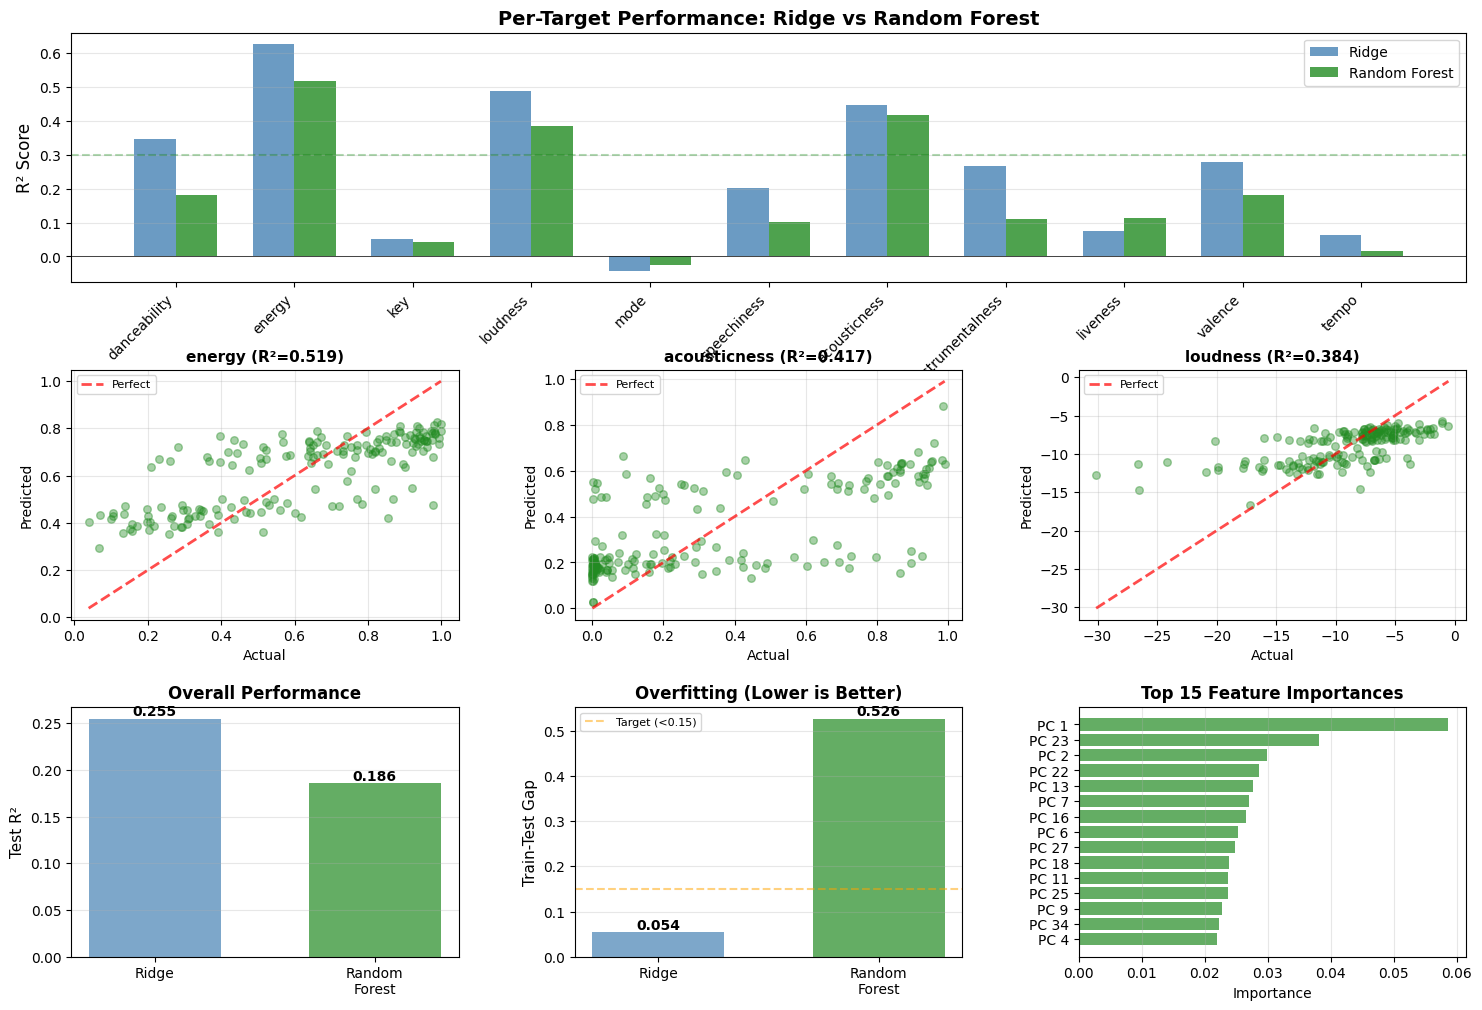

✓ Visualization saved: /home/moad/desktop/music-recommender/data/processed/rf_vs_ridge_comparison.png

🌲 RANDOM FOREST EVALUATION COMPLETE

Metric                                   Ridge              RF       Winner
-------------------------------------------------------------------------
Test R²                                 0.2548          0.1857        Ridge
Gap                                     0.0541          0.5260        Ridge
Strong Predictions                           4               3             

🏆 RECOMMENDATION: Keep Ridge for production


In [85]:
# ==========================================
# ALTERNATIVE MODEL: Optimized Random Forest
# ==========================================

y_train_df = pd.DataFrame(y_train, columns=y.columns)
y_test_df = pd.DataFrame(y_test, columns=y.columns)

print("="*60)
print("ALTERNATIVE MODEL: Random Forest Regression")
print("="*60)

# ==========================================
# STEP 1: Hyperparameter Optimization
# ==========================================
print("\n1. Optimizing Random Forest with RandomizedSearchCV...")
print("-" * 60)

from scipy.stats import randint

param_distributions = {
    'pca__n_components': [0.90, 0.95, 0.98],
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [10, 15, 20, 25, None],
    'rf__min_samples_split': [5, 10, 20, 30],
    'rf__min_samples_leaf': [2, 5, 10, 15],
    'rf__max_features': ['sqrt', 'log2', 0.3, 0.5],
    'rf__bootstrap': [True, False]
}

rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Use RandomizedSearchCV for faster exploration
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions,
    n_iter=50,  # Test 50 combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print("This will test 50 hyperparameter combinations (may take 5-10 minutes)...")
random_search.fit(X_train_extracted, y_train_df)

# Evaluation
best_model = random_search.best_estimator_
train_r2 = random_search.score(X_train_extracted, y_train_df)
cv_r2 = random_search.best_score_
test_r2 = random_search.score(X_test_extracted, y_test_df)
gap = train_r2 - test_r2

y_pred = best_model.predict(X_test_extracted)
test_mae = mean_absolute_error(y_test_df, y_pred)

pca_components = best_model.named_steps['pca'].n_components_

print(f"\nBest Hyperparameters:")
print(f"  PCA variance: {random_search.best_params_['pca__n_components']}")
print(f"  PCA components: {pca_components}")
print(f"  n_estimators: {random_search.best_params_['rf__n_estimators']}")
print(f"  max_depth: {random_search.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {random_search.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {random_search.best_params_['rf__min_samples_leaf']}")
print(f"  max_features: {random_search.best_params_['rf__max_features']}")

print(f"\nOverall Performance:")
print(f"  Train R²: {train_r2:.4f}")
print(f"  CV R²:    {cv_r2:.4f}")
print(f"  Test R²:  {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Gap:      {gap:.4f} {'✓' if gap < 0.15 else '⚠'}")

# ==========================================
# STEP 2: Per-Target Analysis
# ==========================================
print("\n" + "="*60)
print("2. Per-Target Performance")
print("="*60)
print(f"{'Target':<20} {'R²':>8} {'MAE':>10} {'Std Dev':>10} {'Range':>10}")
print("-"*70)

target_metrics = []
for i, target in enumerate(y_test_df.columns):
    r2 = r2_score(y_test_df.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i])
    std = y_test_df.iloc[:, i].std()
    range_val = y_test_df.iloc[:, i].max() - y_test_df.iloc[:, i].min()
    
    target_metrics.append({
        'target': target,
        'r2': r2,
        'mae': mae,
        'std': std,
        'range': range_val
    })
    
    print(f"{target:<20} {r2:>8.4f} {mae:>10.4f} {std:>10.4f} {range_val:>10.4f}")

# Categorize by performance
strong = [m for m in target_metrics if m['r2'] > 0.3]
moderate = [m for m in target_metrics if 0.15 <= m['r2'] <= 0.3]
weak = [m for m in target_metrics if m['r2'] < 0.15]

print(f"\n✓ Strong predictions (R² > 0.3): {len(strong)} targets")
for m in sorted(strong, key=lambda x: x['r2'], reverse=True):
    print(f"  • {m['target']}")

print(f"\n⚠ Moderate predictions (0.15 < R² < 0.3): {len(moderate)} targets")
for m in sorted(moderate, key=lambda x: x['r2'], reverse=True):
    print(f"  • {m['target']}")

print(f"\n❌ Weak predictions (R² < 0.15): {len(weak)} targets")
for m in sorted(weak, key=lambda x: x['r2'], reverse=True):
    print(f"  • {m['target']}")

# ==========================================
# STEP 3: Compare with Ridge
# ==========================================
print("\n" + "="*60)
print("3. Comparison: Random Forest vs Ridge")
print("="*60)

ridge_r2 = 0.2548  # Your Ridge result
ridge_gap = 0.0541

print(f"\n{'Metric':<25} {'Ridge':>12} {'RF':>12} {'Difference':>12}")
print("-"*65)
print(f"{'Test R²':<25} {ridge_r2:>12.4f} {test_r2:>12.4f} {(test_r2-ridge_r2):>+12.4f}")
print(f"{'Gap':<25} {ridge_gap:>12.4f} {gap:>12.4f} {(gap-ridge_gap):>+12.4f}")
print(f"{'Test MAE':<25} {'2.8367':>12} {test_mae:>12.4f} {'':>12}")

if test_r2 > ridge_r2:
    improvement = test_r2 - ridge_r2
    print(f"\n✓ Random Forest WINS by +{improvement:.4f} ({improvement/ridge_r2*100:.1f}%)")
    winner = "Random Forest"
elif abs(test_r2 - ridge_r2) < 0.01:
    print(f"\n≈ TIE - Both models perform similarly (difference < 0.01)")
    winner = "Tie"
else:
    print(f"\n✓ Ridge WINS by +{(ridge_r2-test_r2):.4f}")
    winner = "Ridge"

# ==========================================
# STEP 4: Feature Importance Analysis
# ==========================================
print("\n" + "="*60)
print("4. Feature Importance (Top 20 PCA Components)")
print("="*60)

rf_model = best_model.named_steps['rf']

# Get feature importances (averaged across all target outputs)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
else:
    # Multi-output: average importances across estimators
    importances = np.mean([est.feature_importances_ for est in rf_model.estimators_], axis=0)

# Get top 20
top_n = min(20, len(importances))
top_indices = np.argsort(importances)[-top_n:][::-1]

print(f"\n{'Rank':<6} {'Component':<15} {'Importance':>12}")
print("-"*40)
for rank, idx in enumerate(top_indices, 1):
    print(f"{rank:<6} {'PC_' + str(idx+1):<15} {importances[idx]:>12.6f}")

# ==========================================
# STEP 5: Cross-validation Analysis
# ==========================================
print("\n" + "="*60)
print("5. Cross-Validation Stability")
print("="*60)

cv_results = pd.DataFrame(random_search.cv_results_)
best_idx = random_search.best_index_

cv_scores = [
    cv_results.loc[best_idx, f'split{i}_test_score'] 
    for i in range(5)
]

print(f"\nCV Fold Scores:")
for i, score in enumerate(cv_scores):
    print(f"  Fold {i+1}: {score:.4f}")

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"\nCV Statistics:")
print(f"  Mean: {cv_mean:.4f}")
print(f"  Std:  {cv_std:.4f}")
print(f"  95% CI: [{cv_mean - 1.96*cv_std:.4f}, {cv_mean + 1.96*cv_std:.4f}]")

if cv_std < 0.03:
    print(f"  ✓ Stable model (low variance across folds)")
else:
    print(f"  ⚠ Higher variance - consider more data or regularization")

# ==========================================
# STEP 6: Save Model (if better than Ridge)
# ==========================================
print("\n" + "="*60)
print("6. Saving Model")
print("="*60)

if winner == "Random Forest" or winner == "Tie":
    model_path = prc / "rf_final_model.joblib"
    joblib.dump(best_model, model_path)
    
    metadata = {
        'model_info': {
            'type': 'Random Forest Regression',
            'library': 'scikit-learn',
            'date_trained': str(pd.Timestamp.now()),
        },
        'hyperparameters': {
            'pca_variance_threshold': float(random_search.best_params_['pca__n_components']),
            'pca_components': int(pca_components),
            'n_estimators': int(random_search.best_params_['rf__n_estimators']),
            'max_depth': int(random_search.best_params_['rf__max_depth']) if random_search.best_params_['rf__max_depth'] else None,
            'min_samples_split': int(random_search.best_params_['rf__min_samples_split']),
            'min_samples_leaf': int(random_search.best_params_['rf__min_samples_leaf']),
            'max_features': str(random_search.best_params_['rf__max_features']),
            'bootstrap': bool(random_search.best_params_['rf__bootstrap'])
        },
        'feature_extraction': {
            'original_features': int(X_train_extracted.shape[1]),
            'pca_reduced_features': int(pca_components)
        },
        'performance': {
            'train_r2': float(train_r2),
            'cv_r2': float(cv_r2),
            'test_r2': float(test_r2),
            'test_mae': float(test_mae),
            'train_test_gap': float(gap),
            'cv_std': float(cv_std),
            'per_target': {
                str(m['target']): {
                    'r2': float(m['r2']),
                    'mae': float(m['mae']),
                    'quality': 'strong' if m['r2'] > 0.3 else 'moderate' if m['r2'] > 0.15 else 'weak'
                }
                for m in target_metrics
            }
        },
        'comparison_with_ridge': {
            'ridge_r2': float(ridge_r2),
            'rf_r2': float(test_r2),
            'difference': float(test_r2 - ridge_r2),
            'winner': str(winner)
        }
    }
    
    metadata_path = prc / "rf_model_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✓ Random Forest model saved:")
    print(f"  • Model: {model_path}")
    print(f"  • Metadata: {metadata_path}")
else:
    print("✓ Ridge performs better - keeping Ridge as production model")
    print("  (Random Forest results saved for comparison only)")

# ==========================================
# STEP 7: Visualization
# ==========================================
print("\n" + "="*60)
print("7. Generating Visualizations")
print("="*60)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Per-target R² comparison (Ridge vs RF)
ax1 = fig.add_subplot(gs[0, :])

# Ridge scores (from your previous run)
ridge_scores = {
    'danceability': 0.3470, 'energy': 0.6266, 'key': 0.0520,
    'loudness': 0.4887, 'mode': -0.0434, 'speechiness': 0.2019,
    'acousticness': 0.4475, 'instrumentalness': 0.2658,
    'liveness': 0.0744, 'valence': 0.2794, 'tempo': 0.0628
}

targets = [m['target'] for m in target_metrics]
rf_r2s = [m['r2'] for m in target_metrics]
ridge_r2s = [ridge_scores.get(t, 0) for t in targets]

x = np.arange(len(targets))
width = 0.35

bars1 = ax1.bar(x - width/2, ridge_r2s, width, label='Ridge', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, rf_r2s, width, label='Random Forest', alpha=0.8, color='forestgreen')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.axhline(y=0.3, color='green', linestyle='--', alpha=0.3)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('Per-Target Performance: Ridge vs Random Forest', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(targets, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2-4: Prediction vs Actual (top 3 RF targets)
top_3_indices = np.argsort([m['r2'] for m in target_metrics])[-3:][::-1]

for plot_idx, target_idx in enumerate(top_3_indices):
    ax = fig.add_subplot(gs[1, plot_idx])
    target = target_metrics[target_idx]['target']
    r2 = target_metrics[target_idx]['r2']
    
    actual = y_test_df.iloc[:, target_idx]
    predicted = y_pred[:, target_idx]
    
    ax.scatter(actual, predicted, alpha=0.4, s=30, color='forestgreen')
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()],
           'r--', lw=2, alpha=0.7, label='Perfect')
    ax.set_xlabel('Actual', fontsize=10)
    ax.set_ylabel('Predicted', fontsize=10)
    ax.set_title(f'{target} (R²={r2:.3f})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Plot 5: Model comparison summary
ax5 = fig.add_subplot(gs[2, 0])
models = ['Ridge', 'Random\nForest']
r2_vals = [ridge_r2, test_r2]
colors_comp = ['steelblue', 'forestgreen']

bars = ax5.bar(models, r2_vals, color=colors_comp, alpha=0.7, width=0.6)
ax5.set_ylabel('Test R²', fontsize=11)
ax5.set_title('Overall Performance', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

for bar, r2 in zip(bars, r2_vals):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{r2:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Gap comparison
ax6 = fig.add_subplot(gs[2, 1])
gaps = [ridge_gap, gap]

bars = ax6.bar(models, gaps, color=colors_comp, alpha=0.7, width=0.6)
ax6.axhline(y=0.15, color='orange', linestyle='--', alpha=0.5, label='Target (<0.15)')
ax6.set_ylabel('Train-Test Gap', fontsize=11)
ax6.set_title('Overfitting (Lower is Better)', fontsize=12, fontweight='bold')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3, axis='y')

for bar, gap_val in zip(bars, gaps):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 7: Feature importance (top 15)
ax7 = fig.add_subplot(gs[2, 2])
top_15 = min(15, len(importances))
top_15_indices = np.argsort(importances)[-top_15:]

ax7.barh(range(top_15), importances[top_15_indices], alpha=0.7, color='forestgreen')
ax7.set_yticks(range(top_15))
ax7.set_yticklabels([f'PC {i+1}' for i in top_15_indices])
ax7.set_xlabel('Importance', fontsize=10)
ax7.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')

plt.savefig(prc / 'rf_vs_ridge_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved: {prc / 'rf_vs_ridge_comparison.png'}")

# ==========================================
# FINAL SUMMARY
# ==========================================
print("\n" + "="*70)
print("🌲 RANDOM FOREST EVALUATION COMPLETE")
print("="*70)
print(f"\n{'Metric':<30} {'Ridge':>15} {'RF':>15} {'Winner':>12}")
print("-"*73)
print(f"{'Test R²':<30} {ridge_r2:>15.4f} {test_r2:>15.4f} {winner:>12}")
print(f"{'Gap':<30} {ridge_gap:>15.4f} {gap:>15.4f} {'Ridge' if ridge_gap < gap else 'RF':>12}")
print(f"{'Strong Predictions':<30} {'4':>15} {len(strong):>15} {'':>12}")

print(f"\n{'='*70}")
if winner == "Random Forest":
    print("🏆 RECOMMENDATION: Use Random Forest for production")
elif winner == "Tie":
    print("🤝 RECOMMENDATION: Both models perform similarly")
    print("   Choose based on: Ridge (faster) vs RF (feature importance)")
else:
    print("🏆 RECOMMENDATION: Keep Ridge for production")
print("="*70)